In [1]:
import sys
sys.path.append('..')
import torch
import pennylane as qai
import time

# Related package

import numpy as np
import matplotlib.pyplot as plt

# Hamiltonian related
from openfermion.chem import MolecularData
import openfermion
from openfermionpyscf import run_pyscf

# MISC
r_bohr = 0.529177210903

# Global variable
n_qubits = 4

# 
tolerance = 1e-6
min_pass = 5

# Set molecule parameters.
basis = 'sto-3g'
multiplicity = 1
n_points = 40
bond_length_interval = 3.0 / n_points

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
dev1 = qai.device("default.qubit", wires=n_qubits)

In [2]:
def Rot(alpha, beta, theta, qubit):
    qai.RX(alpha, wires=qubit)
    qai.RY(beta, wires=qubit)
    qai.RZ(theta, wires=qubit)
# Ansatz
def ansatz(params):
    for i in range(n_qubits):
        Rot(params[i][0], params[i][1], params[i][2], i)
    for j in range(n_qubits-1, -1, -1):
        for k in range(j+1, n_qubits):
            qai.CNOT(wires=[j, k])

In [3]:
# Hamiltonian


def get_H2_hamiltonian(distance):
    bond_length=distance*r_bohr
    geometry = [('H', (0., 0., -bond_length/2)), ('H', (0., 0., bond_length/2))]
    molecule = MolecularData(
        geometry, basis, multiplicity,charge=0,
        description=str(round(bond_length, 2)))
    molecule = run_pyscf(molecule,run_scf=1,run_fci=1)
    terms_molecular_hamiltonian = molecule.get_molecular_hamiltonian(occupied_indices=[], active_indices=[0,1])
    fermionic_hamiltonian = openfermion.transforms.get_fermion_operator(terms_molecular_hamiltonian)
    jw_hamiltonian = openfermion.transforms.jordan_wigner(fermionic_hamiltonian)
#     print(jw_hamiltonian.terms)
    print('Hartree-Fock energy of {} Hartree.'.format(molecule.hf_energy))
    print('Hartree-Fock energy of {} Hartree.'.format(molecule.fci_energy))

    return jw_hamiltonian.terms, molecule.fci_energy


In [4]:

def getGateFromName(name):
    if name=="I":
        return qai.Identity
    if name=="X":
        return qai.PauliX
    if name=="Y":
        return qai.PauliY
    if name=="Z":
        return qai.PauliZ
def measurements(gatesPrefix):
    obs = None
    for qubit, gatePrefix in list(gatesPrefix):
        gate = getGateFromName(gatePrefix)
        if obs == None:
            obs = gate(qubit)
        else:
            obs = obs @ gate(qubit)
    if obs == None:
        obs = qai.Identity(0)
    return qai.expval(op=obs)
def initCircuit(distance, circDefList):
    H, fci_energy = get_H2_hamiltonian(distance)
    def circuitDefTemplate(params, obsStr):
        ansatz(params)
        return  measurements(obsStr)
    for i, idx in enumerate(H):
        weightList.append(H[idx])
        circDefList.append(idx)
        
    circ = qai.QNode(circuitDefTemplate, dev1, interface='torch', diff_method="backprop")
    return (circ, fci_energy)


In [5]:
circList = []
circDefList = []
weightList = []
circ, fce = initCircuit(0.1, circDefList)

Hartree-Fock energy of 7.398528409243603 Hartree.
Hartree-Fock energy of 7.39278514106893 Hartree.


In [6]:
circ(torch.ones(4,3), circDefList[5])

tensor(0.2919, dtype=torch.float64)

In [7]:
import torch.nn as nn

distList = np.arange(0.5,1, 0.5)
energyList = np.array([])
fciEnergyList = np.array([])
print(distList)
params = torch.ones(12, requires_grad=True)
# params = torch.rand(12, requires_grad=True)
# params = torch.tensor([3.2203e+00, 5.0488e-02, 1.0000e+00, 3.1412e+00, 3.1412e+00, 1.0000e+00, 3.1407e+00, 1.0005e-03, 1.0000e+00, 4.9604e-04, 2.4310e-03, 1.0000e+00],requires_grad=True)

time_start = time.time()

timestamp = np.array([])
error = np.array([])
for distance in distList:
    circ = None
    circDefList = []
    weightList = []
    circ, fciE = initCircuit(distance, circDefList)
#     params = torch.rand(12, requires_grad=True)
#     params = torch.tensor([3.2203e+00, 5.0488e-02, 1.0000e+00, 3.1412e+00, 3.1412e+00, 1.0000e+00, 3.1407e+00, 1.0005e-03, 1.0000e+00, 4.9604e-04, 2.4310e-03, 1.0000e+00],requires_grad=True)
    optimizer = torch.optim.Adam([params], lr=0.9)
    
#     print(weightList)
    exp = last_exp = 10000
    count = 0.
    for epoch in range(1000):
        l_sum = 0

        loss = nn.L1Loss()
        x = torch.reshape(params, (4,3))
        exp = 0
        for idx, circDef in enumerate(circDefList):   
            psi_H_psi = circ(x, circDef)
            exp += psi_H_psi.real*weightList[idx].real
#             print(psi_H_psi.real, weightList[idx])
            pass
        if epoch%5==0:
            timestamp = np.append(timestamp, time.time()-time_start)
            error = np.append(error, exp.item()-fciE)
            print(epoch, exp.item())
        if np.abs(exp.item()-last_exp)<tolerance:
            count+=1
            if count>min_pass:
                timestamp = np.append(timestamp, time.time()-time_start)
                error = np.append(error, exp.item()-fciE)
                break
        else:
            count = 0
        last_exp = exp.item()
        l = loss(exp, torch.Tensor([-100.]))
        l.backward()        
        optimizer.step()
        optimizer.zero_grad()
    energyList = np.append(energyList, exp.item())
    fciEnergyList = np.append(fciEnergyList, fciE)
time_end = time.time()

[0.5]
Hartree-Fock energy of -0.4033264416010218 Hartree.
Hartree-Fock energy of -0.41078847041741406 Hartree.
0 1.8715241930482847


/usr/local/lib/python3.9/site-packages/torch/nn/modules/loss.py:96: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


5 1.6427321785217521
10 1.3655433960612984
15 1.343248732568176
20 1.35268158171737
25 0.7185168853006447
30 0.16060024330523776
35 -0.027654305715150818
40 -0.26633825552941903
45 -0.3279353737306071
50 -0.3794837527498408
55 -0.39398410409508083
60 -0.39867975946888823
65 -0.3975823518623456
70 -0.4012620735413318
75 -0.40767866375773576
80 -0.40960746516814484
85 -0.4097526176954944
90 -0.4095088982394556
95 -0.4101141441337596
100 -0.41062066716766554
105 -0.4104976838727372
110 -0.4106962357942212
115 -0.41074261880245766
120 -0.4107298076438022
125 -0.41078014178952604
130 -0.4107725086285696
135 -0.4107808048788797
140 -0.4107845329881951
145 -0.41078392075896086
150 -0.4107879307625756
155 -0.4107870733430041


time:  28.413355906


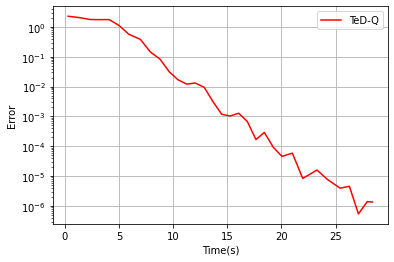

In [8]:
plt.plot(timestamp, error, 'r-', label="TeD-Q")
plt.xlabel('Time(s)')
plt.grid()
plt.ylabel('Error')
plt.gca().set_yscale('log')
plt.legend()
print("time: ", time_end-time_start)

In [13]:
distList = np.arange(0.5,3.5, 0.1)
energyList = np.array([])
fciEnergyList = np.array([])
print(distList)
params = torch.ones(12, requires_grad=True)
# params = torch.rand(12, requires_grad=True)
# params = torch.tensor([3.2203e+00, 5.0488e-02, 1.0000e+00, 3.1412e+00, 3.1412e+00, 1.0000e+00, 3.1407e+00, 1.0005e-03, 1.0000e+00, 4.9604e-04, 2.4310e-03, 1.0000e+00],requires_grad=True)

time_start = time.time()

for distance in distList:
    time_epoch_start = time.time()
    circ = None
    circDefList = []
    weightList = []
    circ, fciE = initCircuit(distance, circDefList)
#     params = torch.rand(12, requires_grad=True)
#     params = torch.tensor([3.2203e+00, 5.0488e-02, 1.0000e+00, 3.1412e+00, 3.1412e+00, 1.0000e+00, 3.1407e+00, 1.0005e-03, 1.0000e+00, 4.9604e-04, 2.4310e-03, 1.0000e+00],requires_grad=True)
    optimizer = torch.optim.Adam([params], lr=0.9)
    
#     print(weightList)
    exp = last_exp = 10000
    count = 0.
    for epoch in range(1000):
        l_sum = 0

        loss = nn.L1Loss()
        x = torch.reshape(params, (4,3))
        exp = 0
        for idx, circDef in enumerate(circDefList):   
            psi_H_psi = circ(x, circDef)
            exp += psi_H_psi.real*weightList[idx].real
#             print(psi_H_psi.real, weightList[idx])
            pass
            
        if epoch%5==0:
            print(epoch, exp.item())
        if np.abs(exp.item()-last_exp)<tolerance:
            count+=1
            if count>min_pass:
                break
        
        else:
            count = 0
        if time.time()-time_epoch_start>5:
            break
        last_exp = exp.item()
        l = loss(exp, torch.Tensor([-100.]))
        l.backward()        
        optimizer.step()
        optimizer.zero_grad()
    energyList = np.append(energyList, exp.item())
    fciEnergyList = np.append(fciEnergyList, fciE)
time_end = time.time()

[0.5 0.6 0.7 0.8 0.9 1.  1.1 1.2 1.3 1.4 1.5 1.6 1.7 1.8 1.9 2.  2.1 2.2
 2.3 2.4 2.5 2.6 2.7 2.8 2.9 3.  3.1 3.2 3.3 3.4]
Hartree-Fock energy of -0.4033264416010218 Hartree.
Hartree-Fock energy of -0.41078847041741406 Hartree.
0 1.8715241930482847
5 1.6427321785217521
10 1.3655433960612984
15 1.343248732568176
20 1.35268158171737
25 0.7185168853006447
Hartree-Fock energy of -0.6682564110880089 Hartree.
Hartree-Fock energy of -0.6765108103840292 Hartree.
0 -0.17570018835400017
5 -0.1298666770058847
10 -0.5042329078477551
15 -0.5869160659304287
20 -0.6006223609273511
25 -0.6278103490863461
Hartree-Fock energy of -0.837130298190518 Hartree.
Hartree-Fock energy of -0.8463259843661401 Hartree.
0 -0.7952463821204184
5 -0.3428277699347263
10 -0.6149193863443851
15 -0.7070056419059818
20 -0.7732740896870587
25 -0.7814257036555259
30 -0.8160721826372159
Hartree-Fock energy of -0.9473079310932639 Hartree.
Hartree-Fock energy of -0.9575985319987075 Hartree.
0 -0.9312718269474716
5 -0.57205825373

time:  -152.55044731400005


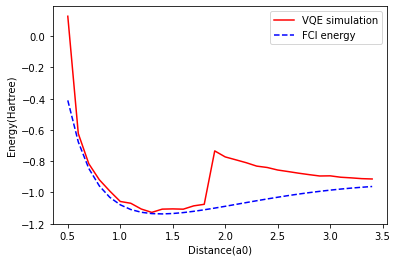

In [14]:
plt.plot(distList, energyList, 'r-', label="VQE simulation")
plt.plot(distList, fciEnergyList, 'b--', label="FCI energy")
plt.xlabel('Distance(a0)')

plt.ylabel('Energy(Hartree)')
plt.legend()
print("time: ", time_start-time_end)

In [15]:
distList = np.arange(0.5,3.5, 0.1)
energyList_1 = np.array([])
fciEnergyList = np.array([])
print(distList)
params = torch.ones(12, requires_grad=True)
# params = torch.rand(12, requires_grad=True)
# params = torch.tensor([3.2203e+00, 5.0488e-02, 1.0000e+00, 3.1412e+00, 3.1412e+00, 1.0000e+00, 3.1407e+00, 1.0005e-03, 1.0000e+00, 4.9604e-04, 2.4310e-03, 1.0000e+00],requires_grad=True)

time_start = time.time()

for distance in distList:
    time_epoch_start = time.time()
    circ = None
    circDefList = []
    weightList = []
    circ, fciE = initCircuit(distance, circDefList)
#     params = torch.rand(12, requires_grad=True)
#     params = torch.tensor([3.2203e+00, 5.0488e-02, 1.0000e+00, 3.1412e+00, 3.1412e+00, 1.0000e+00, 3.1407e+00, 1.0005e-03, 1.0000e+00, 4.9604e-04, 2.4310e-03, 1.0000e+00],requires_grad=True)
    optimizer = torch.optim.Adam([params], lr=0.9)
    
#     print(weightList)
    exp = last_exp = 10000
    count = 0.
    for epoch in range(1000):
        l_sum = 0

        loss = nn.L1Loss()
        x = torch.reshape(params, (4,3))
        exp = 0
        for idx, circDef in enumerate(circDefList):   
            psi_H_psi = circ(x, circDef)
            exp += psi_H_psi.real*weightList[idx].real
#             print(psi_H_psi.real, weightList[idx])
            pass
            
        if epoch%5==0:
            print(epoch, exp.item())
        if np.abs(exp.item()-last_exp)<tolerance:
            count+=1
            if count>min_pass:
                break
        
        else:
            count = 0
        if time.time()-time_epoch_start>20:
            break
        last_exp = exp.item()
        l = loss(exp, torch.Tensor([-100.]))
        l.backward()        
        optimizer.step()
        optimizer.zero_grad()
    energyList_1 = np.append(energyList_1, exp.item())
time_end = time.time()

[0.5 0.6 0.7 0.8 0.9 1.  1.1 1.2 1.3 1.4 1.5 1.6 1.7 1.8 1.9 2.  2.1 2.2
 2.3 2.4 2.5 2.6 2.7 2.8 2.9 3.  3.1 3.2 3.3 3.4]
Hartree-Fock energy of -0.4033264416010218 Hartree.
Hartree-Fock energy of -0.41078847041741406 Hartree.
0 1.8715241930482847


/usr/local/lib/python3.9/site-packages/torch/nn/modules/loss.py:96: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


5 1.6427321785217521
10 1.3655433960612984
15 1.343248732568176
20 1.35268158171737
25 0.7185168853006447
30 0.16060024330523776
35 -0.027654305715150818
40 -0.26633825552941903
45 -0.3279353737306071
50 -0.3794837527498408
55 -0.39398410409508083
60 -0.39867975946888823
65 -0.3975823518623456
70 -0.4012620735413318
75 -0.40767866375773576
80 -0.40960746516814484
85 -0.4097526176954944
90 -0.4095088982394556
95 -0.4101141441337596
100 -0.41062066716766554
105 -0.4104976838727372
110 -0.4106962357942212
115 -0.41074261880245766
120 -0.4107298076438022
Hartree-Fock energy of -0.6682564110880089 Hartree.
Hartree-Fock energy of -0.6765108103840292 Hartree.
0 -0.6763587872113203
5 -0.43334497579055553
10 -0.32762752491035657
15 -0.49327090974334065
20 -0.5992609355962359
25 -0.6439111197037314
30 -0.6392506719348695
35 -0.657392127963595
40 -0.6663718944140542
45 -0.6680159157461766
50 -0.6728130148801407
55 -0.6742205589996236
60 -0.6746597544383477
65 -0.6755383808087148
70 -0.67579892535

0 -1.110608188024099
5 -0.9493738532487612
10 -0.9751675238568159
15 -1.0360830246967145
20 -1.0651298010482424
25 -1.08840748531469
30 -1.1034998649842118
35 -1.1036450461353247
40 -1.1037043754910731
45 -1.1083598611914947
50 -1.109536531716448
55 -1.10940346464466
60 -1.1102337697271538
65 -1.1105014128795685
70 -1.1105641216768007
75 -1.1107481461264856
80 -1.110707497840517
85 -1.1108029233911785
90 -1.1108237686158695
95 -1.1108170962838528
100 -1.110840561739818
105 -1.1108381469925017
110 -1.11084069080417
Hartree-Fock energy of -1.0645768781375606 Hartree.
Hartree-Fock energy of -1.0999996208265852 Hartree.
0 -1.0997753610447036
5 -0.9410160543401492
10 -0.9743087260238531
15 -1.0348199207818938
20 -1.0588726875036492
25 -1.0750385408585035
30 -1.0939143048795201
35 -1.0942927157723317
40 -1.092087470640412
45 -1.0982292524066457
50 -1.0987265665603405
55 -1.0985781202389244
60 -1.0996009896314345
65 -1.0995556661923391
70 -1.0998103269770707
75 -1.0998424193171406
80 -1.09991

110 -0.9782897227657593
115 -0.9782884084600376
120 -0.978290178577932
Hartree-Fock energy of -0.8560969196807475 Hartree.
Hartree-Fock energy of -0.9721473744174565 Hartree.
0 -0.971806611655232
5 -0.910083185954204
10 -0.9098744912553087
15 -0.9325487211738017
20 -0.9404904252226127
25 -0.948729591644419
30 -0.9568998221661831
35 -0.963442047850872
40 -0.969731916464303
45 -0.9702925518154661
50 -0.9710304617699704
55 -0.970715186473255
60 -0.9717853562516325
65 -0.9719021054746546
70 -0.971856779757314
75 -0.9720846203546969
80 -0.972065877980729
85 -0.9721081516697084
90 -0.9721293795236959
95 -0.9721258397222114
100 -0.9721386009422053
105 -0.9721403317783792
110 -0.9721444689220187
115 -0.9721460461372795
120 -0.9721456580137696
Hartree-Fock energy of -0.8422970366437781 Hartree.
Hartree-Fock energy of -0.966692672976077 Hartree.
0 -0.9663805487944551
5 -0.8529257023393874
10 -0.9433458102675292
15 -0.9331855839024878
20 -0.9301403287295106
25 -0.946758650791796
30 -0.96016809510

In [17]:
np.savez('vqe_pennylane.npz', t=timestamp, e=error, d=distList, el=energyList, el1=energyList_1, rel=fciEnergyList)

##### 